# Homework 05
## Özlem Ölçer ID: 69217

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.spatial as spa
from scipy.stats import multivariate_normal as mv_normal

Importing Data

In [2]:
data_set = np.genfromtxt("hw05_data_set.csv", delimiter = ",")
initial_centroids = np.genfromtxt("hw05_initial_centroids.csv", delimiter=",")

x1 = data_set[:, 0]
x2 = data_set[:, 1]

## 5 Distinct Classes
K = 5

## Class sizes
N_class = np.zeros(K)
N_class[:] = 150

## Class 1 and 5 has size 275
N_class[0] = 275
N_class[4] = 275

## For a total of 1000 points
N = data_set.shape[0]


Class Means and Coveriances

In [3]:
class_means = np.zeros((K,2))
class_cov = np.zeros((K, 2, 2))

class_means[0] = [+0.0, +5.5]
class_means[1] = [-5.5, +0.0]
class_means[2] = [+0.0, +0.0]
class_means[3] = [+5.5, +0.0]
class_means[4] = [+0.0, -5.5]


class_cov[0] = [[+4.8, +0.0], [+0.0, +0.4]]
class_cov[1] = [[+0.4, +0.0], [+0.0, +2.8]]
class_cov[2] = [[+2.4, +0.0], [+0.0, +2.4]]
class_cov[3] = [[+0.4, +0.0], [+0.0, +2.8]]
class_cov[4] = [[+4.8, +0.0], [+0.0, +0.4]]

In [4]:
def update_memberships(centroids, X):
    # calculate distances between centroids and data points
    D = spa.distance_matrix(centroids, X)
    # find the nearest centroid for each data point
    memberships = np.argmin(D, axis = 0)
    return(memberships)

Initialize EM Algorithm

In [5]:
# Calculate nearest centroid for each data point
est_memberships = update_memberships(initial_centroids, data_set)


## Phi Parameters
est_probability = np.array(np.bincount(est_memberships)) / N
est_class_size = np.array(np.bincount(est_memberships))
est_class_cov = np.array([
    np.transpose(np.mat(data_set[est_memberships == k] - initial_centroids[k])) * np.mat(data_set[est_memberships == k] - initial_centroids[k]) / est_class_size[k] for k in range(K)])


E-Step and M-Step Algorithms

In [7]:
def e_step(initial_centroids, est_class_cov, est_probability, data_set):
    ## Use Multivariate Gaussian Normal function (mv_normal)
    membership_probabilities = np.zeros((N, K))
    for k in range(K):
        for n in range(N):
            denom = np.sum([mv_normal.pdf(data_set[n], initial_centroids[c], est_class_cov[c]) * est_probability[c] for c in range(K)], axis=0)
            nom = mv_normal.pdf(data_set[n], initial_centroids[k], est_class_cov[k]) * est_probability[k]
            membership_probabilities[n, k] = nom/denom
    return membership_probabilities

In [8]:
def m_step(data_set, mp):
    centroids = np.zeros((K, 2))
    est_class_cov = np.zeros((K, 2, 2))
    est_probability = np.zeros(K)

    for k in range(K):
        ## Centroids
        centroids[k] = np.sum([(data_set[n] * mp[n, k]) for n in range(N)], axis=0) / np.sum(mp[:, k])
        ## Class Covariances
        nom = np.sum([np.multiply(np.matmul(np.transpose(np.asmatrix(data_set[n] - centroids[k])), np.asmatrix(data_set[n] - centroids[k])), mp[n, k]) for n in range(N)], axis = 0)
        denom = np.sum(mp[:, k])
        est_class_cov[k] = nom/denom
        ## Probabilities
        est_probability[k] = np.sum(mp[:, k], axis=0) / N

    return centroids, est_class_cov, est_probability

In [9]:
for i in range(1, 101):
    ## Expectation
    membership_probs = e_step(initial_centroids, est_class_cov, est_probability, data_set)

    ## Maximization
    initial_centroids, est_class_cov, est_probability = m_step(data_set, membership_probs)

print("Mean Vectors after 100 iterations:\n", initial_centroids)

Mean Vectors after 100 iterations:
 [[ 0.15012647 -0.10601062]
 [ 5.63782309 -0.01720488]
 [-0.06077502 -5.60092697]
 [-0.08487478  5.45469879]
 [-5.4828878  -0.08822559]]


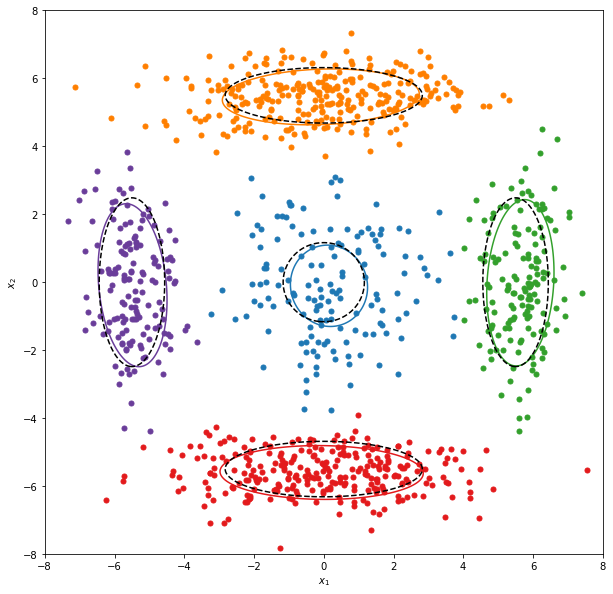

In [10]:
est_memberships = np.argmax(membership_probs, axis=1)

plt.figure(figsize=(10, 10))

cluster_colors = np.array(["#1f78b4", "#33a02c", "#e31a1c", "#ff7f00", "#6a3d9a", "#b15928",
                               "#a6cee3", "#b2df8a", "#fb9a99", "#fdbf6f", "#cab2d6", "#ffff99"])
if est_memberships is None:
    plt.plot(data_set[:,0], data_set[:,1], ".", markersize = 10, color = "black")
else:
    for c in range(K):
        plt.plot(data_set[est_memberships == c, 0], data_set[est_memberships == c, 1], ".", markersize = 10, color = cluster_colors[c])
   
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")


x1_grid, x2_grid = np.meshgrid(np.linspace(-8, +8, 1600), np.linspace(-8, +8, 1600))
intervals = np.dstack((x1_grid, x2_grid))

for k in range(K):
    em_points = mv_normal(initial_centroids[k], est_class_cov[k]).pdf(intervals)
    plt.contour(x1_grid, x2_grid, em_points, colors=cluster_colors[k], levels=[0.05])
        
for k in range(K):
    given_points = mv_normal(class_means[k], class_cov[k]).pdf(intervals)
    plt.contour(x1_grid, x2_grid, given_points, linestyles='dashed', levels=[0.05], colors='k')
    
plt.show()